# %% [markdown]

 ## 4. Verdict-wise Analysis

 This analyzes verdicts given by the LLM actors and human redditors to the moral dilemmas.

In [ ]:
# %%

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import krippendorff
from itertools import combinations
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
# %%

def extract_actor_labels(df):
    """
    Extract actor names and ALL their label columns from the dataframe.
    Returns a dict mapping actor name to a list of their label column names.
    """
    allowed_actors = [
        "reddit",
        "gpt3.5",
        "gpt4",
        "claude",
        "bison",
        "llama",
        "mistral",
        "gemma",
        "gemini",
    ]

    actor_dict = {}

    for actor in allowed_actors:
        actor_cols = [col for col in df.columns if col.startswith(f"{actor}_label")]
        if actor_cols:
            actor_dict[actor] = actor_cols

    return actor_dict

In [ ]:
# %%

def calculate_verdict_fractions(df, actor_dict):
    """
    Calculate the fraction of each verdict for each actor.
    Aggregates counts across all label columns for each actor.
    Returns (fractions_df, counts_df, totals_series).
    """
    verdicts = ["NTA", "YTA", "NAH", "ESH", "INFO"]
    fraction_results = {}
    count_results = {}
    totals = {}

    for actor, cols in actor_dict.items():
        all_verdicts = pd.Series(dtype=object)
        for col in cols:
            all_verdicts = pd.concat([all_verdicts, df[col].dropna()])

        all_verdicts = all_verdicts.replace("INF", "INFO")

        verdict_counts = all_verdicts.value_counts()
        total = len(all_verdicts)

        fractions = {}
        counts = {}
        for verdict in verdicts:
            count = verdict_counts.get(verdict, 0)
            counts[verdict] = count
            fractions[verdict] = count / total if total > 0 else 0

        fraction_results[actor] = fractions
        count_results[actor] = counts
        totals[actor] = total

    fractions_df = pd.DataFrame(fraction_results).T
    counts_df = pd.DataFrame(count_results).T.fillna(0).astype(int)
    totals_series = pd.Series(totals)

    return fractions_df, counts_df, totals_series

In [ ]:
# %%

def plot_verdict_distribution(fractions_df, totals_series, title):
    """
    Create a grouped bar chart showing verdict distribution for each actor.
    """
    actor_name_map = {
        "reddit": "Redditor",
        "gpt3.5": "GPT-3.5",
        "gpt4": "GPT-4",
        "claude": "Claude Haiku",
        "bison": "PaLM 2 Bison",
        "gemini": "Gemini 2",
        "llama": "Llama 2 7B",
        "mistral": "Mistral 7B",
        "gemma": "Gemma 7B",
    }

    ordered_actors = [
        actor for actor in actor_name_map.keys() if actor in fractions_df.index
    ]
    if ordered_actors:
        fractions_df = fractions_df.loc[ordered_actors]
        totals_series = totals_series.loc[ordered_actors]

    actor_keys = list(fractions_df.index)
    display_index = [actor_name_map.get(actor, actor.upper()) for actor in actor_keys]
    fractions_display = fractions_df.copy()
    fractions_display.index = display_index

    _, ax = plt.subplots(figsize=(12, 6))

    verdicts = ["NTA", "YTA", "NAH", "ESH", "INFO"]
    colors = [
        "#3274A1",
        "#E1812C",
        "#3A923A",
        "#C03D3E",
        "#9372B2",
        "#8B4513",
        "#FF69B4",
        "#808080",
    ]

    x = np.arange(len(verdicts))
    width = 0.1
    n_actors = len(fractions_df)

    offset = width * n_actors / 2 - width / 2

    for i, actor_key in enumerate(actor_keys):
        row = fractions_df.loc[actor_key]
        display_name = fractions_display.index[i]
        values = [row[verdict] for verdict in verdicts]
        total = totals_series.get(actor_key, 0)
        errors = [np.sqrt(p * (1 - p) / total) if total > 0 else 0 for p in values]
        position = x + (i * width) - offset
        _ = ax.bar(
            position,
            values,
            width,
            label=display_name,
            color=colors[i % len(colors)],
        )

        ax.errorbar(
            position,
            values,
            yerr=errors,
            fmt="none",
            ecolor="black",
            capsize=2,
            alpha=0.5,
            linewidth=0.5,
        )

    ax.set_ylabel("Fraction of Posts", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(verdicts, fontsize=12)
    ax.set_ylim(0, 1.0)
    ax.grid(axis="y", alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
    ax.set_title(title, fontsize=14, pad=20)

    plt.tight_layout()
    plt.show()

In [ ]:
# %%

def encode_verdicts(series):
    """
    Encode verdicts as numeric values for Krippendorff's alpha.
    """
    encoding = {"NTA": 0, "YTA": 1, "NAH": 2, "ESH": 3, "INFO": 4, "INF": 4}
    return series.map(encoding)

In [ ]:
# %%

def calculate_krippendorff_alpha(df, col1, col2):
    """
    Calculate Krippendorff's alpha between two label columns.
    Returns alpha value or np.nan if calculation fails.
    """
    data1 = encode_verdicts(df[col1])
    data2 = encode_verdicts(df[col2])

    valid_mask = data1.notna() & data2.notna()
    if valid_mask.sum() < 2:
        return np.nan

    reliability_data = np.array([data1.values, data2.values])

    try:
        alpha = krippendorff.alpha(
            reliability_data=reliability_data, level_of_measurement="nominal"
        )
        return alpha
    except Exception as e:
        print(f"  Warning: Could not calculate alpha for {col1} vs {col2}: {e}")
        return np.nan

In [ ]:
# %%

def calculate_pairwise_alpha_average(df, actor1_cols, actor2_cols):
    """
    Calculate Krippendorff's alpha for all pairs of columns between two actors
    and return the average.
    """
    alphas = []

    for col1 in actor1_cols:
        for col2 in actor2_cols:
            if col1 == col2:
                continue

            alpha = calculate_krippendorff_alpha(df, col1, col2)
            if not np.isnan(alpha):
                alphas.append(alpha)

    return np.mean(alphas) if alphas else np.nan

In [ ]:
# %%

def calculate_diagonal_alpha(df, actor_cols):
    """
    Calculate average Krippendorff's alpha between all pairs within the same actor.
    This measures intra-rater reliability.
    """
    if len(actor_cols) < 2:
        return 1.0

    alphas = []
    for col1, col2 in combinations(actor_cols, 2):
        alpha = calculate_krippendorff_alpha(df, col1, col2)
        if not np.isnan(alpha):
            alphas.append(alpha)

    return np.mean(alphas) if alphas else np.nan

In [ ]:
# %%

def build_krippendorff_matrix(df, actor_dict):
    """
    Build a matrix of Krippendorff's alpha values for all actor pairs.
    """
    actors = list(actor_dict.keys())
    n_actors = len(actors)
    alpha_matrix = np.zeros((n_actors, n_actors))

    for i, actor1 in enumerate(actors):
        for j, actor2 in enumerate(actors):
            if i == j:
                alpha_matrix[i, j] = calculate_diagonal_alpha(df, actor_dict[actor1])
            else:
                alpha_matrix[i, j] = calculate_pairwise_alpha_average(
                    df, actor_dict[actor1], actor_dict[actor2]
                )

    return pd.DataFrame(alpha_matrix, index=actors, columns=actors)

In [ ]:
# %%

def plot_krippendorff_heatmap(alpha_df, title):
    """
    Create a heatmap of Krippendorff's alpha values.
    """
    actor_name_map = {
        "reddit": "Redditor",
        "gpt3.5": "GPT-3.5",
        "gpt4": "GPT-4",
        "claude": "Claude Haiku",
        "bison": "PaLM 2 Bison",
        "gemini": "Gemini 2",
        "llama": "Llama 2 7B",
        "mistral": "Mistral 7B",
        "gemma": "Gemma 7B",
    }

    ordered_actors = [
        actor for actor in actor_name_map.keys() if actor in alpha_df.index
    ]
    if ordered_actors:
        alpha_df = alpha_df.loc[ordered_actors, ordered_actors]

    alpha_df.index = [
        actor_name_map.get(actor, actor.upper()) for actor in alpha_df.index
    ]
    alpha_df.columns = [
        actor_name_map.get(actor, actor.upper()) for actor in alpha_df.columns
    ]

    plt.figure(figsize=(10, 8))

    colors = ["#A50026", "#FFFFFF", "#000000"]
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

    sns.heatmap(
        alpha_df,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=1,
        cbar_kws={"label": "Krippendorff's Alpha", "shrink": 0.8},
    )

    plt.title(title, fontsize=14, pad=20)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    plt.show()


English (Base)

Verdict fractions:
              NTA       YTA       NAH       ESH      INFO
reddit   0.764831  0.169644  0.020824  0.020731  0.023970
gpt3.5   0.552645  0.310196  0.004658  0.108437  0.024063
gpt4     0.754651  0.127210  0.063026  0.054466  0.000648
claude   0.873145  0.078359  0.012957  0.035076  0.000463
bison    0.881351  0.071325  0.028598  0.018171  0.000555
llama    0.005861  0.793953  0.148326  0.051859  0.000000
mistral  0.075983  0.059016  0.395434  0.357365  0.112201
gemma    0.610588  0.146617  0.000389  0.242314  0.000093

Verdict counts:
           NTA    YTA    NAH    ESH  INFO
reddit    8264   1833    225    224   259
gpt3.5   17914  10055    151   3515   780
gpt4     16308   2749   1362   1177    14
claude   28303   2540    420   1137    15
bison    28569   2312    927    589    18
llama      190  25736   4808   1681     0
mistral   2463   1913  12818  11584  3637
gemma    32987   7921     21  13091     5


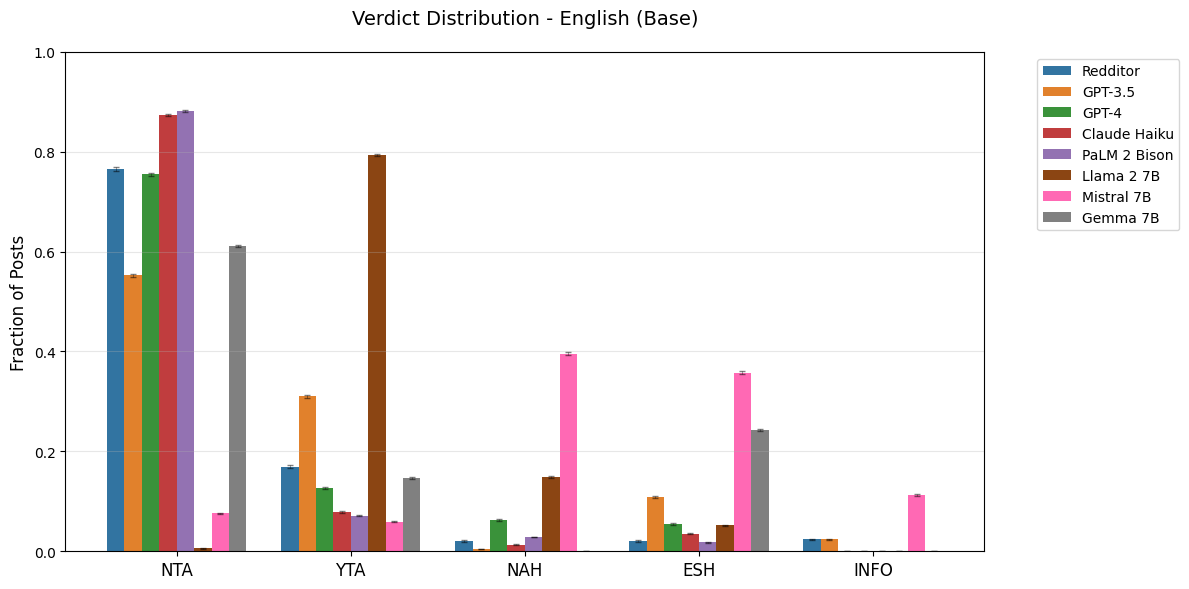


Krippendorff's Alpha Matrix:
           reddit    gpt3.5      gpt4    claude     bison     llama   mistral  \
reddit   1.000000  0.259583  0.519990  0.278647  0.332493 -0.398723 -0.219474   
gpt3.5   0.259583  0.658138  0.319740  0.163590  0.137586 -0.205058 -0.089216   
gpt4     0.519990  0.319740  0.895728  0.378744  0.422039 -0.390071 -0.169026   
claude   0.278647  0.163590  0.378744  0.909264  0.461736 -0.513058 -0.272873   
bison    0.332493  0.137586  0.422039  0.461736  0.781766 -0.527427 -0.292378   
llama   -0.398723 -0.205058 -0.390071 -0.513058 -0.527427  0.344586 -0.224150   
mistral -0.219474 -0.089216 -0.169026 -0.272873 -0.292378 -0.224150  0.690835   
gemma   -0.029974  0.030402 -0.007619 -0.015416 -0.054695 -0.305474 -0.125093   

            gemma  
reddit  -0.029974  
gpt3.5   0.030402  
gpt4    -0.007619  
claude  -0.015416  
bison   -0.054695  
llama   -0.305474  
mistral -0.125093  
gemma    0.362997  


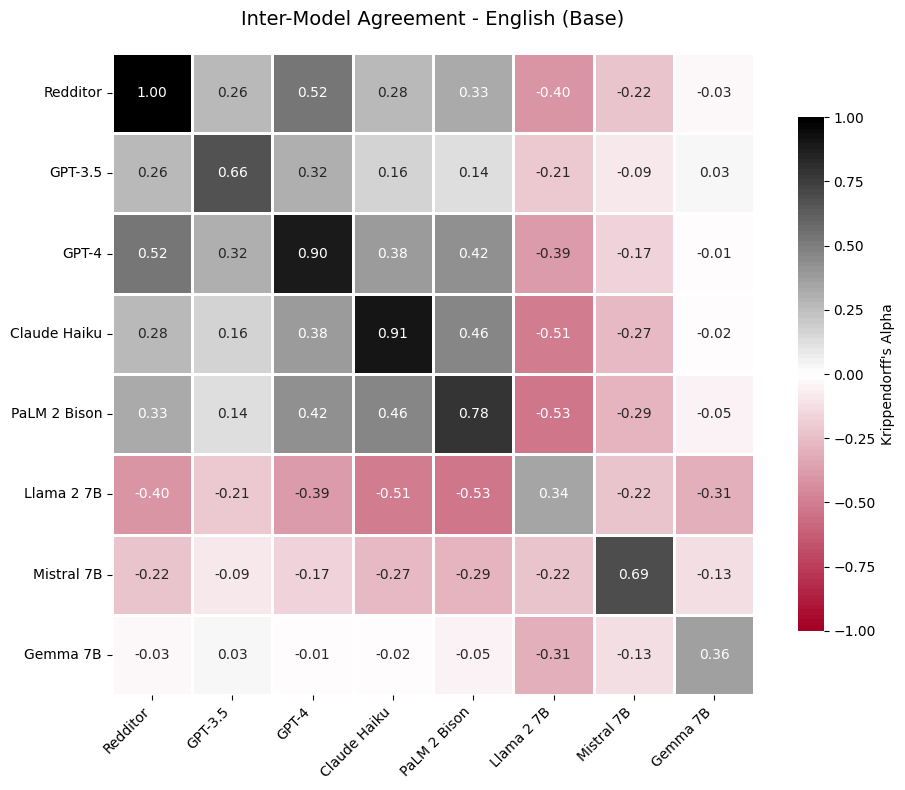


Portuguese

Verdict fractions:
              NTA       YTA       NAH       ESH      INFO
reddit   0.775000  0.118750  0.062500  0.025000  0.018750
gpt3.5   0.627273  0.143939  0.130303  0.087879  0.010606
gpt4     0.510606  0.143939  0.166667  0.175758  0.003030
claude   0.607576  0.050000  0.036364  0.306061  0.000000
llama    0.122888  0.751152  0.087558  0.035330  0.003072
mistral  0.369444  0.391667  0.147222  0.052778  0.038889
gemma    0.000000  0.838652  0.010638  0.134752  0.015957
gemini   0.534848  0.277273  0.143939  0.040909  0.003030

Verdict counts:
         NTA  YTA  NAH  ESH  INFO
reddit   124   19   10    4     3
gpt3.5   414   95   86   58     7
gpt4     337   95  110  116     2
claude   401   33   24  202     0
llama     80  489   57   23     2
mistral  133  141   53   19    14
gemma      0  473    6   76     9
gemini   353  183   95   27     2


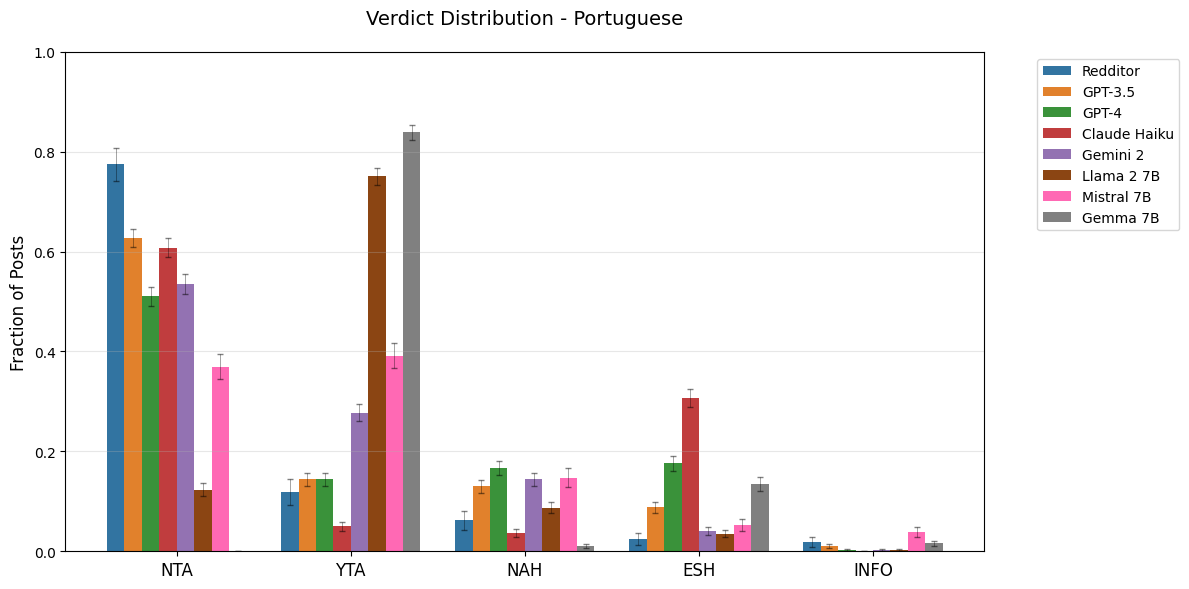


Krippendorff's Alpha Matrix:
           reddit    gpt3.5      gpt4    claude     llama   mistral     gemma  \
reddit   1.000000  0.151346  0.113795  0.103923 -0.343787 -0.135847 -0.433679   
gpt3.5   0.151346  0.676392  0.281607  0.205311 -0.236957 -0.039755 -0.290755   
gpt4     0.113795  0.281607  0.701961  0.290212 -0.170922 -0.047885 -0.272848   
claude   0.103923  0.205311  0.290212  0.778754 -0.290380 -0.108901 -0.376206   
llama   -0.343787 -0.236957 -0.170922 -0.290380  0.507194 -0.110816 -0.004279   
mistral -0.135847 -0.039755 -0.047885 -0.108901 -0.110816  0.027506 -0.165178   
gemma   -0.433679 -0.290755 -0.272848 -0.376206 -0.004279 -0.165178  0.559634   
gemini   0.087991  0.280293  0.302597  0.150001 -0.129609 -0.011563 -0.219229   

           gemini  
reddit   0.087991  
gpt3.5   0.280293  
gpt4     0.302597  
claude   0.150001  
llama   -0.129609  
mistral -0.011563  
gemma   -0.219229  
gemini   0.768637  


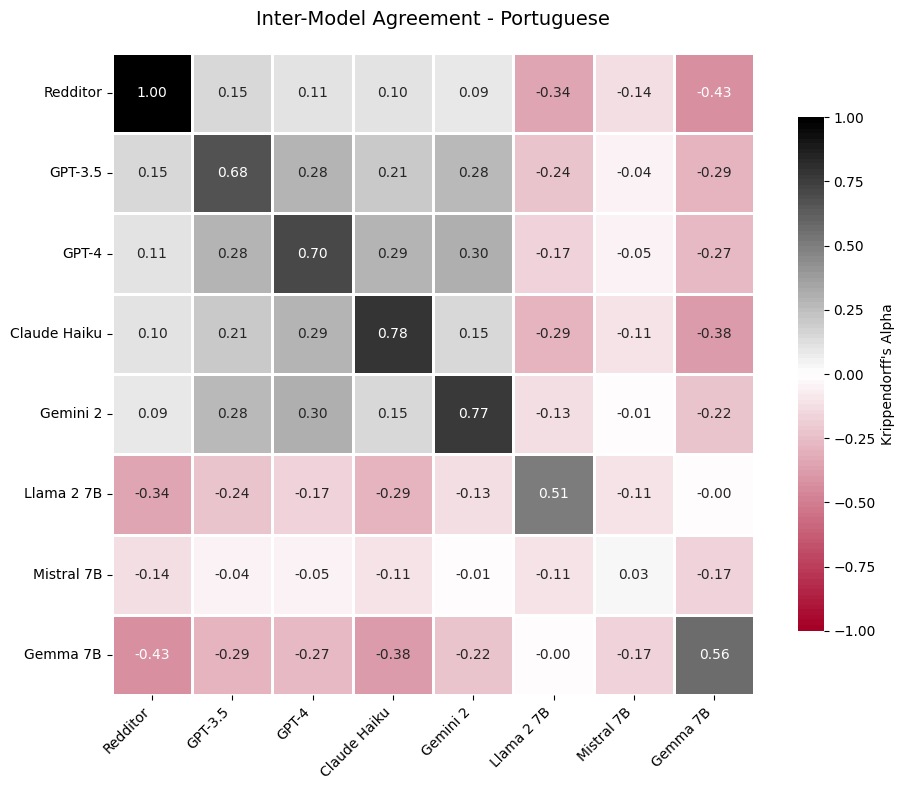


German

Verdict fractions:
              NTA       YTA       NAH       ESH      INFO
reddit   0.767442  0.058140  0.094961  0.038760  0.040698
gpt3.5   0.691860  0.076550  0.129845  0.069767  0.031977
gpt4     0.625969  0.057171  0.111434  0.198643  0.006783
claude   0.756783  0.015504  0.045543  0.182171  0.000000
llama    0.167387  0.589633  0.186825  0.053996  0.002160
mistral  0.420191  0.360164  0.121419  0.050477  0.047749
gemma    0.001120  0.428891  0.045913  0.518477  0.005599
gemini   0.692829  0.260659  0.005814  0.039729  0.000969

Verdict counts:
         NTA  YTA  NAH  ESH  INFO
reddit   396   30   49   20    21
gpt3.5   714   79  134   72    33
gpt4     646   59  115  205     7
claude   781   16   47  188     0
llama    155  546  173   50     2
mistral  308  264   89   37    35
gemma      1  383   41  463     5
gemini   715  269    6   41     1


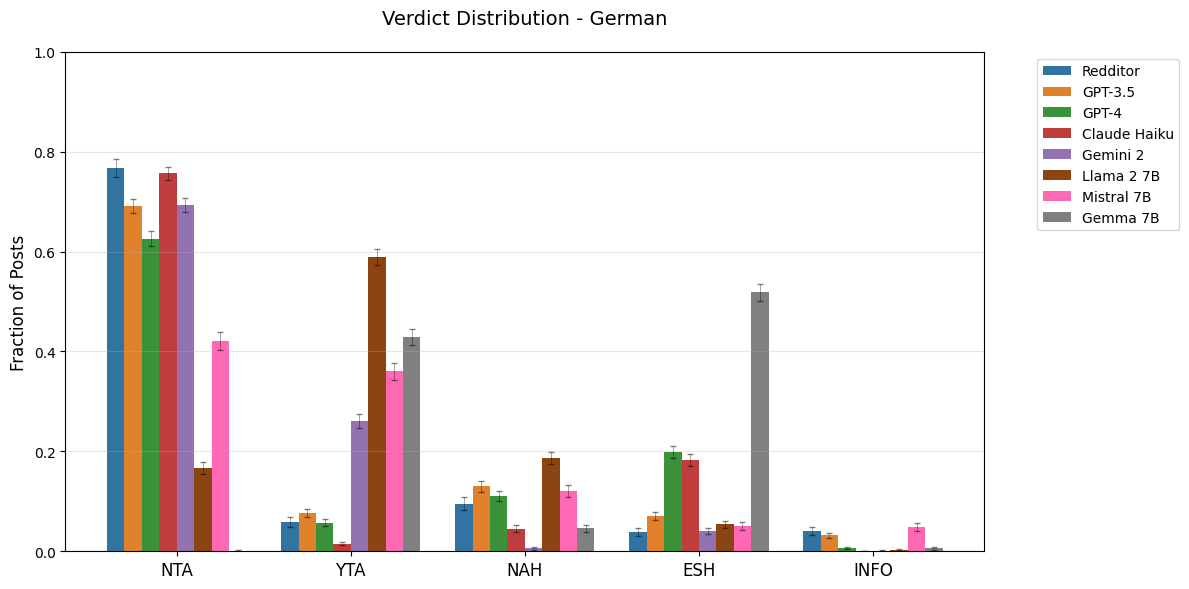


Krippendorff's Alpha Matrix:
           reddit    gpt3.5      gpt4    claude     llama   mistral     gemma  \
reddit   1.000000  0.066978  0.099447  0.131691 -0.250304 -0.106133 -0.311056   
gpt3.5   0.066978  0.614916  0.206523  0.218188 -0.216500 -0.086527 -0.256160   
gpt4     0.099447  0.206523  0.754911  0.331164 -0.179601 -0.053389 -0.192887   
claude   0.131691  0.218188  0.331164  0.797385 -0.255394 -0.121045 -0.271886   
llama   -0.250304 -0.216500 -0.179601 -0.255394  0.369366 -0.093430 -0.143293   
mistral -0.106133 -0.086527 -0.053389 -0.121045 -0.093430 -0.009292 -0.107628   
gemma   -0.311056 -0.256160 -0.192887 -0.271886 -0.143293 -0.107628  0.610081   
gemini   0.056234  0.156501  0.190088  0.163429 -0.157740 -0.039899 -0.246188   

           gemini  
reddit   0.056234  
gpt3.5   0.156501  
gpt4     0.190088  
claude   0.163429  
llama   -0.157740  
mistral -0.039899  
gemma   -0.246188  
gemini   0.853856  


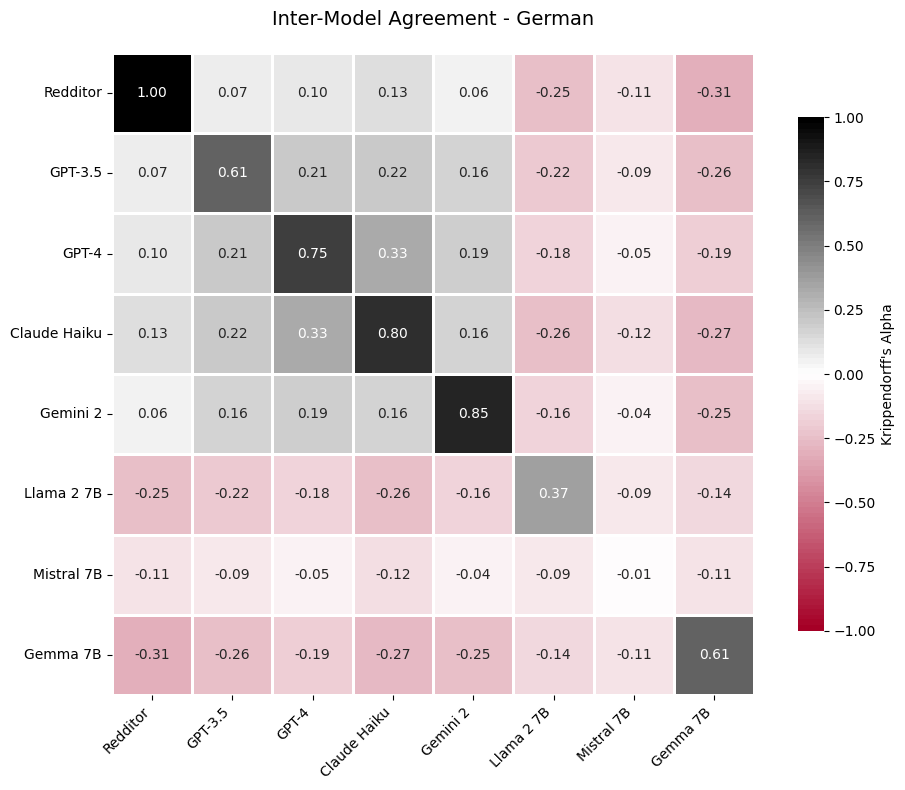


French

Verdict fractions:
              NTA       YTA       NAH       ESH      INFO
reddit   0.737609  0.125364  0.052478  0.058309  0.026239
gpt3.5   0.709220  0.083924  0.083924  0.109929  0.013002
gpt4     0.453901  0.102837  0.172577  0.269504  0.001182
claude   0.580569  0.039100  0.022512  0.357820  0.000000
llama    0.254502  0.570228  0.084034  0.091236  0.000000
mistral  0.292505  0.332724  0.126143  0.073126  0.175503
gemma    0.000000  0.532300  0.038760  0.425065  0.003876
gemini   0.601655  0.219858  0.122931  0.055556  0.000000

Verdict counts:
         NTA  YTA  NAH  ESH  INFO
reddit   253   43   18   20     9
gpt3.5   600   71   71   93    11
gpt4     384   87  146  228     1
claude   490   33   19  302     0
llama    212  475   70   76     0
mistral  160  182   69   40    96
gemma      0  412   30  329     3
gemini   509  186  104   47     0


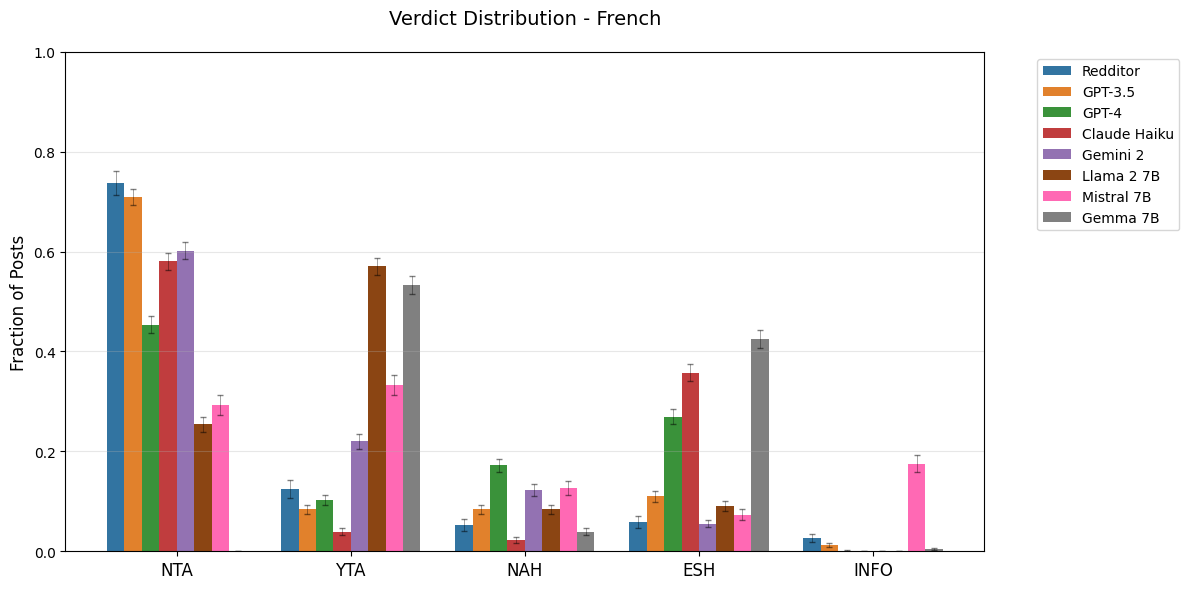


Krippendorff's Alpha Matrix:
           reddit    gpt3.5      gpt4    claude     llama   mistral     gemma  \
reddit   1.000000  0.069979  0.051185  0.098055 -0.169631 -0.097472 -0.304992   
gpt3.5   0.069979  0.573567  0.220468  0.213877 -0.213506 -0.097650 -0.264944   
gpt4     0.051185  0.220468  0.722604  0.273272 -0.091362 -0.051986 -0.094368   
claude   0.098055  0.213877  0.273272  0.751263 -0.148933 -0.054292 -0.180877   
llama   -0.169631 -0.213506 -0.091362 -0.148933  0.385631 -0.052482 -0.050010   
mistral -0.097472 -0.097650 -0.051986 -0.054292 -0.052482 -0.010003 -0.042893   
gemma   -0.304992 -0.264944 -0.094368 -0.180877 -0.050010 -0.042893  0.632549   
gemini   0.082442  0.266822  0.267436  0.146183 -0.102615 -0.057131 -0.177214   

           gemini  
reddit   0.082442  
gpt3.5   0.266822  
gpt4     0.267436  
claude   0.146183  
llama   -0.102615  
mistral -0.057131  
gemma   -0.177214  
gemini   0.801669  


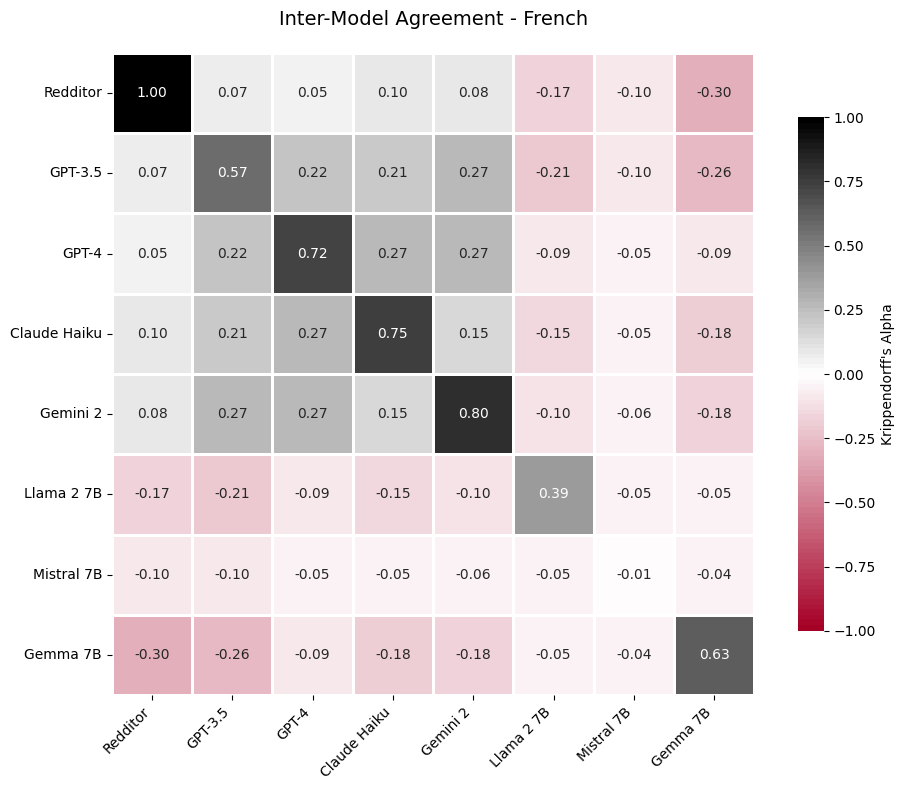


Spanish

Verdict fractions:
              NTA       YTA       NAH       ESH      INFO
reddit   0.000000  0.000000  0.000000  0.000000  0.000000
gpt3.5   0.508197  0.290984  0.061475  0.106557  0.032787
gpt4     0.463115  0.110656  0.184426  0.209016  0.032787
claude   0.500000  0.057377  0.040984  0.393443  0.008197
llama    0.629167  0.166667  0.145833  0.058333  0.000000
mistral  0.306569  0.459854  0.145985  0.007299  0.080292
gemma    0.000000  0.261307  0.070352  0.643216  0.025126
gemini   0.348361  0.381148  0.192623  0.069672  0.008197

Verdict counts:
         NTA  YTA  NAH  ESH  INFO
reddit     0    0    0    0     0
gpt3.5   124   71   15   26     8
gpt4     113   27   45   51     8
claude   122   14   10   96     2
llama    151   40   35   14     0
mistral   42   63   20    1    11
gemma      0   52   14  128     5
gemini    85   93   47   17     2


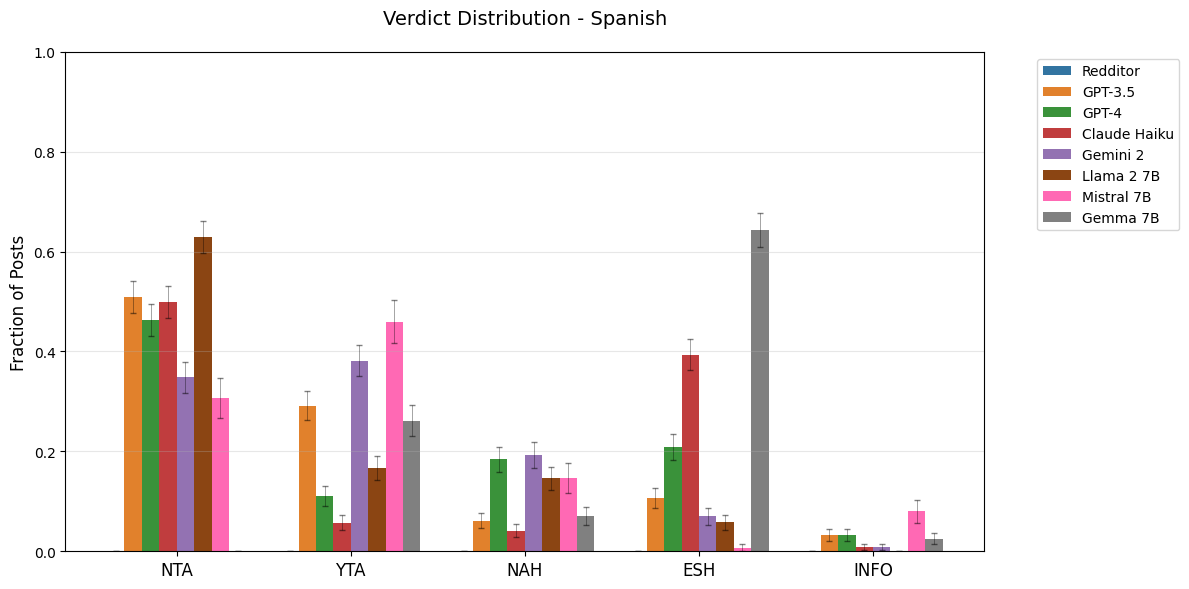


Krippendorff's Alpha Matrix:
         reddit    gpt3.5      gpt4    claude     llama   mistral     gemma  \
reddit      1.0       NaN       NaN       NaN       NaN       NaN       NaN   
gpt3.5      NaN  0.643340  0.228088  0.208535 -0.072147 -0.002113 -0.125071   
gpt4        NaN  0.228088  0.647383  0.287490 -0.025450 -0.029616 -0.064137   
claude      NaN  0.208535  0.287490  0.751025 -0.064911 -0.135184 -0.064395   
llama       NaN -0.072147 -0.025450 -0.064911  0.326574 -0.133601 -0.204751   
mistral     NaN -0.002113 -0.029616 -0.135184 -0.133601  0.138289 -0.101265   
gemma       NaN -0.125071 -0.064137 -0.064395 -0.204751 -0.101265  0.383646   
gemini      NaN  0.242696  0.296105  0.162820 -0.054416  0.033802 -0.020809   

           gemini  
reddit        NaN  
gpt3.5   0.242696  
gpt4     0.296105  
claude   0.162820  
llama   -0.054416  
mistral  0.033802  
gemma   -0.020809  
gemini   0.858309  


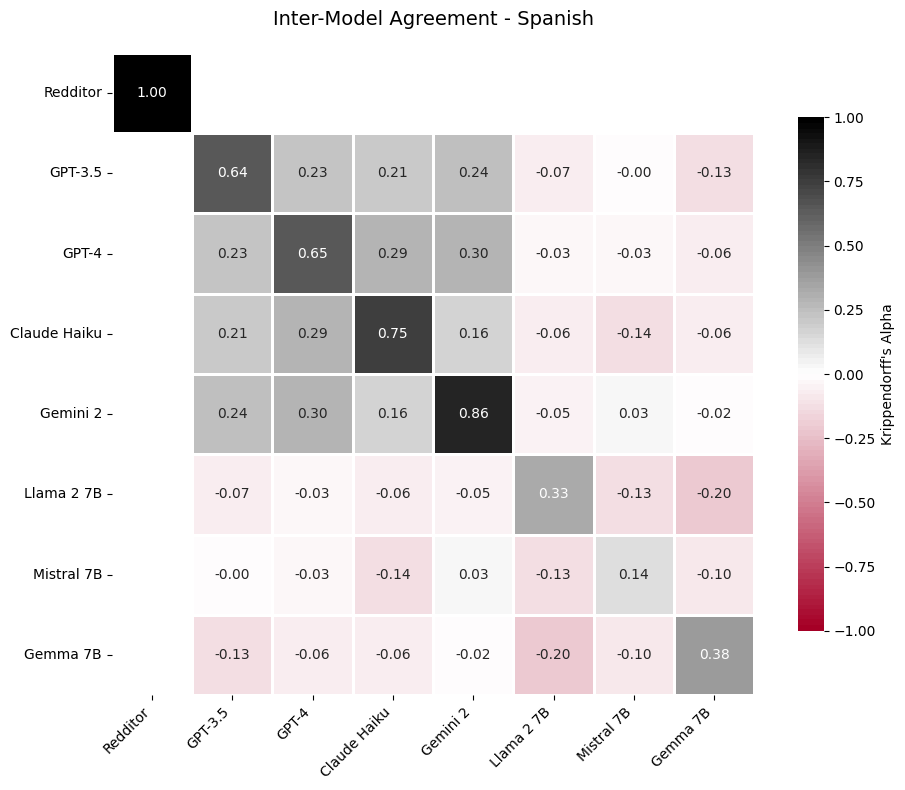

In [ ]:
# %%

datasets = [
    ("moral_dilemmas_cleaned.csv", "English (Base)"),
    ("moral_dilemmas_cleaned_br.csv", "Portuguese"),
    ("moral_dilemmas_cleaned_de.csv", "German"),
    ("moral_dilemmas_cleaned_fr.csv", "French"),
    ("moral_dilemmas_cleaned_es.csv", "Spanish"),
]

data_dir = Path("../data")

for filename, language in datasets:
    print(f"\n{'='*60}")
    print(f"{language}")
    print(f"{'='*60}")

    df = pd.read_csv(data_dir / filename)

    actor_dict = extract_actor_labels(df)

    fractions_df, counts_df, totals_series = calculate_verdict_fractions(df, actor_dict)
    print(f"\nVerdict fractions:\n{fractions_df}")
    print(f"\nVerdict counts:\n{counts_df}")

    title = f"Verdict Distribution - {language}"
    plot_verdict_distribution(fractions_df, totals_series, title)

    alpha_df = build_krippendorff_matrix(df, actor_dict)
    print(f"\nKrippendorff's Alpha Matrix:\n{alpha_df}")

    title = f"Inter-Model Agreement - {language}"
    plot_krippendorff_heatmap(alpha_df, title)